In [1]:
!pip uninstall -y pillow
!pip install pillow==10.0.1
# Core
!pip -q install -U ultralytics transformers torch torchvision pillow matplotlib opencv-python pyyaml

# NOTE:
# - `Sam3Model` and `Sam3Processor` come from `transformers` (as in your SAM3 notebook).
# - If you're on Apple Silicon / CPU-only, SAM3 can be slow; CUDA is recommended.
!pip install -U git+https://github.com/huggingface/transformers.git

Found existing installation: pillow 12.0.0
Uninstalling pillow-12.0.0:
  Successfully uninstalled pillow-12.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 10.0.1 which is incompatible.


In [13]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from huggingface_hub import login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
import os
import re
import io
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import cv2
import torch
import yaml
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

from ultralytics import YOLO
from transformers import Sam3Processor, Sam3Model

In [16]:
def load_image(image_path: str) -> Image.Image:
    img = Image.open(image_path).convert("RGB")
    return img

def pil_to_np_rgb(img: Image.Image) -> np.ndarray:
    return np.array(img)  # RGB

def np_rgb_to_pil(arr: np.ndarray) -> Image.Image:
    return Image.fromarray(arr.astype(np.uint8), mode="RGB")

def ensure_device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
def overlay_binary_masks(
    image: Image.Image,
    masks: List[np.ndarray],
    alpha: float = 0.45,
) -> Image.Image:
    """Overlay list of HxW boolean/0-1 masks on image (RGBA compositing)."""
    if len(masks) == 0:
        return image

    rgba = image.convert("RGBA")
    w, h = rgba.size

    # Use a colormap without hardcoding colors (matplotlib chooses)
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(len(masks))

    for i, m in enumerate(masks):
        if m.dtype != np.uint8:
            m = (m > 0).astype(np.uint8) * 255
        else:
            m = (m > 0).astype(np.uint8) * 255

        color = tuple(int(c * 255) for c in cmap(i)[:3])
        overlay = Image.new("RGBA", (w, h), color + (0,))
        mask_img = Image.fromarray(m, mode="L")
        # alpha mask: where mask=255, apply alpha
        a = mask_img.point(lambda v: int((v/255) * 255 * alpha))
        overlay.putalpha(a)
        rgba = Image.alpha_composite(rgba, overlay)

    return rgba.convert("RGB")


def draw_labels(
    image: Image.Image,
    boxes_xyxy: List[Tuple[int,int,int,int]],
    labels: List[str],
) -> Image.Image:
    """Draw simple boxes + labels using OpenCV."""
    arr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    for (x1,y1,x2,y2), lab in zip(boxes_xyxy, labels):
        cv2.rectangle(arr, (x1,y1), (x2,y2), (0, 255, 0), 2)
        cv2.putText(arr, lab, (x1, max(0,y1-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
    return Image.fromarray(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))

In [18]:
@dataclass
class FacadeElementClassifier:
    """Wrapper around an Ultralytics YOLO model trained to detect/classify facade elements."""
    weights_path: str
    device: Optional[str] = None
    conf: float = 0.25
    imgsz: int = 384

    _model: Any = field(default=None, init=False, repr=False)

    def load(self):
        self.device = self.device or (0 if torch.cuda.is_available() else "cpu")
        self._model = YOLO(self.weights_path)
        return self

    def predict_top_label(self, image: Image.Image) -> Tuple[Optional[str], float]:
        """Returns (label, score). If no detection, label=None."""
        if self._model is None:
            raise RuntimeError("Classifier not loaded. Call .load() first.")

        # Ultralytics accepts PIL directly
        results = self._model.predict(
            source=image,
            imgsz=self.imgsz,
            conf=self.conf,
            device=self.device,
            verbose=False
        )

        r = results[0]
        if r.boxes is None or len(r.boxes) == 0:
            return None, 0.0

        # Choose the highest confidence detection and return its class name
        confs = r.boxes.conf.detach().cpu().numpy()
        cls_ids = r.boxes.cls.detach().cpu().numpy().astype(int)
        best_i = int(np.argmax(confs))
        cls_id = int(cls_ids[best_i])
        score = float(confs[best_i])
        name = r.names.get(cls_id, str(cls_id))
        return name, score

In [19]:
@dataclass
class Sam3Segmenter:
    """Wrapper for SAM3 instance segmentation with text prompts."""
    model_name: str = "facebook/sam3"
    device: Optional[str] = None
    threshold: float = 0.6
    mask_threshold: float = 0.5

    _model: Any = field(default=None, init=False, repr=False)
    _processor: Any = field(default=None, init=False, repr=False)

    def load(self):
        self.device = self.device or ensure_device()
        self._model = Sam3Model.from_pretrained(self.model_name).to(self.device)
        self._processor = Sam3Processor.from_pretrained(self.model_name)
        self._model.eval()
        return self

    @torch.no_grad()
    def segment(self, image: Image.Image, prompt: str, *, threshold: Optional[float]=None, mask_threshold: Optional[float]=None) -> Dict[str, Any]:
        """Run SAM3 with a text prompt. Returns dict with 'masks', 'scores', etc."""
        if self._model is None or self._processor is None:
            raise RuntimeError("SAM3 not loaded. Call .load() first.")

        inputs = self._processor(images=image, text=prompt, return_tensors="pt").to(self.device)
        outputs = self._model(**inputs)

        res = self._processor.post_process_instance_segmentation(
            outputs,
            threshold=self.threshold if threshold is None else float(threshold),
            mask_threshold=self.mask_threshold if mask_threshold is None else float(mask_threshold),
            target_sizes=inputs["original_sizes"].tolist(),
        )[0]

        # Convert to CPU tensors for downstream processing
        res_cpu = {}
        for k, v in res.items():
            if torch.is_tensor(v):
                res_cpu[k] = v.detach().cpu()
            else:
                res_cpu[k] = v
        res_cpu["prompt"] = prompt
        return res_cpu


In [20]:
@dataclass
class DefectRule:
    """One defect rule: run one or more SAM3 prompts and convert the results into defect masks."""
    name: str
    prompts: List[str]
    # Optional post-processing parameters (extend as needed)
    min_area_px: int = 200
    max_area_frac: float = 0.7   # discard masks covering too much of image
    score_threshold: float = 0.0 # (SAM3 returns scores; keep >= this)

    def apply(self, image: Image.Image, sam: Sam3Segmenter) -> List[Dict[str, Any]]:
        h, w = image.size[1], image.size[0]
        img_area = h * w

        found: List[Dict[str, Any]] = []

        for prompt in self.prompts:
            res = sam.segment(image, prompt)
            masks = res.get("masks", None)
            scores = res.get("scores", None)

            if masks is None or len(masks) == 0:
                continue

            masks_np = masks.numpy().astype(bool)  # [N,H,W]
            scores_np = scores.numpy() if scores is not None else np.ones((masks_np.shape[0],), dtype=float)

            for i in range(masks_np.shape[0]):
                if float(scores_np[i]) < self.score_threshold:
                    continue

                m = masks_np[i]
                area = int(m.sum())
                if area < self.min_area_px:
                    continue
                if area > int(self.max_area_frac * img_area):
                    continue

                found.append({
                    "defect": self.name,
                    "prompt": prompt,
                    "score": float(scores_np[i]),
                    "mask": m,  # bool HxW
                })

        return found

In [74]:
@dataclass
class FacadeDefectDetector:
    classifier: FacadeElementClassifier
    segmenter: Sam3Segmenter

    @staticmethod
    def _normalize_element_label(label: Optional[Any]) -> Optional[str]:
        """
        Normalizes YOLO output label into one of: "0", "1", "2", or None.

        Handles cases where YOLO returns:
          - None
          - [] / empty list / empty tuple / empty dict
          - "0" / "1" / "2"
          - "facade_element1" / "facade_element2" / "element0"
          - "class 1" / "1 - something" / etc.
        """
        if label is None:
            return None

        # Treat empty container as "no detection"
        if isinstance(label, (list, tuple, dict)) and len(label) == 0:
            return None

        # If container has values, use first item
        if isinstance(label, (list, tuple)) and len(label) > 0:
            label = label[0]

        s = str(label).strip().lower()
        if s in ("", "none", "null"):
            return None

        # Direct mapping if classes are named like this
        direct_map = {
            "facade_element0": "0",
            "facade_element1": "1",
            "facade_element2": "2",
        }
        if s in direct_map:
            return direct_map[s]

        # Already digits
        if s.isdigit():
            return s

        # Pattern: facade_element1 / facade-element2 / element0
        m = re.search(r"(?:facade[_\-\s]*element|element)\s*[_\-\s]*([0-9]+)", s)
        if m:
            return m.group(1)

        # Fallback: last digit sequence anywhere (captures "facade_element1")
        m = re.search(r"(\d+)(?!.*\d)", s)
        if m:
            return m.group(1)

        return None

    @staticmethod
    def _sam_count(
        image: Image.Image,
        sam: Sam3Segmenter,
        prompt: str,
        *,
        threshold: Optional[float] = None,
        mask_threshold: Optional[float] = None,
        debug: Optional[List[str]] = None
    ) -> Dict[str, Any]:
        used_thr = sam.threshold if threshold is None else float(threshold)
        used_mthr = sam.mask_threshold if mask_threshold is None else float(mask_threshold)

        if debug is not None:
            debug.append(f"[SAM3] prompt='{prompt}' threshold={used_thr} mask_threshold={used_mthr}")

        res = sam.segment(image, prompt, threshold=used_thr, mask_threshold=used_mthr)

        masks = res.get("masks", None)
        scores = res.get("scores", None)

        if masks is None or len(masks) == 0:
            if debug is not None:
                debug.append("[SAM3] -> count=0 (no masks returned)")
            return {
                "count": 0,
                "masks": np.zeros((0, image.size[1], image.size[0]), dtype=bool),
                "scores": np.zeros((0,), dtype=float),
                "prompt": prompt,
                "threshold": used_thr,
                "mask_threshold": used_mthr,
            }

        masks_np = masks.detach().cpu().numpy().astype(bool)
        scores_np = scores.detach().cpu().numpy() if scores is not None else np.ones((masks_np.shape[0],), dtype=float)

        if debug is not None:
            top = np.sort(scores_np)[::-1][:5]
            debug.append(f"[SAM3] -> count={masks_np.shape[0]} top_scores={np.round(top, 4).tolist()}")

        return {
            "count": int(masks_np.shape[0]),
            "masks": masks_np,
            "scores": scores_np,
            "prompt": prompt,
            "threshold": used_thr,
            "mask_threshold": used_mthr,
        }

    def load(self):
        self.classifier.load()
        self.segmenter.load()
        return self

    def infer(
        self,
        image: Image.Image,
        *,
        debug: bool = False,
        print_debug: bool = False,
    ) -> Dict[str, Any]:
        """
        Runs the full pipeline and returns a dict result.

        Options:
          - debug=True: include 'debug' lines in the returned dict (inference["debug"])
          - print_debug=True: print the debug lines after inference
        """
        debug_lines: Optional[List[str]] = [] if (debug or print_debug) else None

        raw_label, element_score = self.classifier.predict_top_label(image)
        element = self._normalize_element_label(raw_label)

        if debug_lines is not None:
            debug_lines.append(f"[YOLO] raw_label={raw_label!r} normalized={element!r} score={element_score:.4f}")

        defects: List[Dict[str, Any]] = []

        def add_defect(name: str, prompt: str, mask: Optional[np.ndarray] = None, score: Optional[float] = None):
            defects.append({
                "defect": name,
                "prompt": prompt,
                "score": None if score is None else float(score),
                "mask": mask,
            })
            if debug_lines is not None:
                debug_lines.append(f"[DEFECT] + {name} (from prompt='{prompt}')")

        # ---------------------------
        # EXACT DEFECT LOGIC (your spec)
        # ---------------------------

        # 0 or None (includes [] / empty)
        if element in (None, "0"):
            if debug_lines is not None:
                debug_lines.append(
                    "[RULE] element is 0 or None -> prompt 'small circle hole' (thr=0.4); "
                    "if count==1 => 'screw missing'"
                )

            r = self._sam_count(image, self.segmenter, "small circle hole", threshold=0.4, debug=debug_lines)

            if r["count"] == 1:
                i = int(np.argmax(r["scores"])) if r["scores"].size else 0
                add_defect(
                    "screw missing",
                    r["prompt"],
                    mask=r["masks"][i],
                    score=float(r["scores"][i]) if r["scores"].size else None
                )
            else:
                if debug_lines is not None:
                    debug_lines.append(f"[RULE] 'small circle hole' count={r['count']} -> no 'screw missing' (needs exactly 1)")

        # Class 1
        elif element == "1":
            if debug_lines is not None:
                debug_lines.append(
                    "[RULE] element is 1 -> "
                    "orange area (<2), orange divisor (==0), black curve (>=1), cracked glass (thr=0.95, >=1)"
                )

            # (1) orange area
            r_orange = self._sam_count(image, self.segmenter, "orange area", debug=debug_lines)
            if r_orange["count"] < 2:
                missing = 2 - r_orange["count"]  # found 1 -> missing 1 ; found 0 -> missing 2
                add_defect(f"{missing} orange metal sheet missing", r_orange["prompt"])
            else:
                if debug_lines is not None:
                    debug_lines.append(f"[RULE] 'orange area' count={r_orange['count']} -> no missing orange sheets")

            # (2) orange divisor  ✅ NEW RULE
            r_div = self._sam_count(image, self.segmenter, "orange divisor", threshold=0.25, debug=debug_lines)
            if r_div["count"] == 0:
                add_defect("orange divisor missing", r_div["prompt"])
            else:
                if debug_lines is not None:
                    debug_lines.append(f"[RULE] 'orange divisor' count={r_div['count']} -> divisor present")

            # (3) black curve
            r_black = self._sam_count(image, self.segmenter, "black curve", debug=debug_lines)
            if r_black["count"] >= 1:
                i = int(np.argmax(r_black["scores"])) if r_black["scores"].size else 0
                add_defect(
                    "seal broken",
                    r_black["prompt"],
                    mask=r_black["masks"][i],
                    score=float(r_black["scores"][i]) if r_black["scores"].size else None
                )
            else:
                if debug_lines is not None:
                    debug_lines.append("[RULE] 'black curve' count=0 -> no 'seal broken'")

            # (4) cracked tempered glass panel (thr=0.95)
            r_glass = self._sam_count(
                image,
                self.segmenter,
                "a cracked tempered glass panel",
                threshold=0.95,
                debug=debug_lines
            )
            if r_glass["count"] >= 1:
                i = int(np.argmax(r_glass["scores"])) if r_glass["scores"].size else 0
                add_defect(
                    "broken glass",
                    r_glass["prompt"],
                    mask=r_glass["masks"][i],
                    score=float(r_glass["scores"][i]) if r_glass["scores"].size else None
                )
            else:
                if debug_lines is not None:
                    debug_lines.append("[RULE] 'a cracked tempered glass panel' count=0 -> no 'broken glass'")

        # Class 2
        elif element == "2":
            if debug_lines is not None:
                debug_lines.append("[RULE] element is 2 -> prompt 'red area'; if count==0 => 'red metal sheet missing'")

            r_red = self._sam_count(image, self.segmenter, "red area", debug=debug_lines)
            if r_red["count"] == 0:
                add_defect("red metal sheet missing", r_red["prompt"])
            else:
                if debug_lines is not None:
                    debug_lines.append(f"[RULE] 'red area' count={r_red['count']} -> no 'red metal sheet missing'")

        else:
            if debug_lines is not None:
                debug_lines.append(f"[RULE] element={element!r} not in {{None,'0','1','2'}} -> no rules applied")

        status = "FAIL" if len(defects) > 0 else "PASS"

        if print_debug and debug_lines is not None:
            print("\n".join(debug_lines))

        by_defect: Dict[str, List[Dict[str, Any]]] = {}
        for d in defects:
            by_defect.setdefault(d["defect"], []).append(d)

        out: Dict[str, Any] = {
            "element": element,
            "element_raw": raw_label,
            "element_score": float(element_score),
            "status": status,
            "defects": defects,
            "defects_by_type": by_defect,
        }

        if debug and debug_lines is not None:
            out["debug"] = debug_lines

        return out

    # --- Reports ---
    def make_solution_report(self, image_path: str, inference: Dict[str, Any]) -> str:
        fname = os.path.basename(image_path)
        defects_list = [d["defect"] for d in inference.get("defects", [])]
        defects_str = ", ".join(defects_list) if defects_list else ""
        return f"Image: {fname}\nStatus: {inference.get('status','FAIL')}\nDefects: {defects_str}"

    def make_detailed_report(self, image_path: str, inference: Dict[str, Any]) -> str:
        fname = os.path.basename(image_path)
        defects_list = [d["defect"] for d in inference.get("defects", [])]
        defects_str = ", ".join(defects_list) if defects_list else ""

        lines = [
            f"Image: {fname}",
            f"Status: {inference.get('status','')}",
            f"Defects: {defects_str}",
            "",
            f"Predicted element (raw): {inference.get('element_raw')!r}",
            f"Predicted element (normalized): {inference.get('element')!r}",
            f"Classifier score: {inference.get('element_score', 0.0):.4f}",
        ]

        dbg = inference.get("debug", None)
        if dbg:
            lines.append("")
            lines.append("Debug log:")
            lines.extend(dbg)

        return "\n".join(lines)

    def visualize(self, image: Image.Image, inference: Dict[str, Any]) -> Image.Image:
        masks = [d["mask"] for d in inference.get("defects", []) if d.get("mask") is not None]
        out = overlay_binary_masks(image, masks)

        header = (
            f"class={inference.get('element_raw')}→{inference.get('element')} "
            f"({inference.get('element_score',0):.2f}) | {inference.get('status','')}"
        )
        arr = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
        cv2.rectangle(arr, (0, 0), (arr.shape[1], 32), (0, 0, 0), -1)
        cv2.putText(arr, header, (8, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
        return Image.fromarray(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))

In [88]:
# 1) Point to your trained YOLO weights (from Explore_&_Classification notebook)
# Example (change this to your actual best.pt path):
YOLO_WEIGHTS = "/content/drive/MyDrive/Neodata Hackathon 2025/YOLO/models/facade_yolov8n_best.pt"

# 2) Point to an image to test
IMAGE_PATH = "/content/drive/MyDrive/Neodata Hackathon 2025/sample_images/11_1.jpg"

In [84]:
# Load models
detector = FacadeDefectDetector(
    classifier=FacadeElementClassifier(weights_path=YOLO_WEIGHTS),
    segmenter=Sam3Segmenter(model_name="facebook/sam3"),
).load()

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Image: 11_1.jpg
Status: FAIL
Defects: broken glass


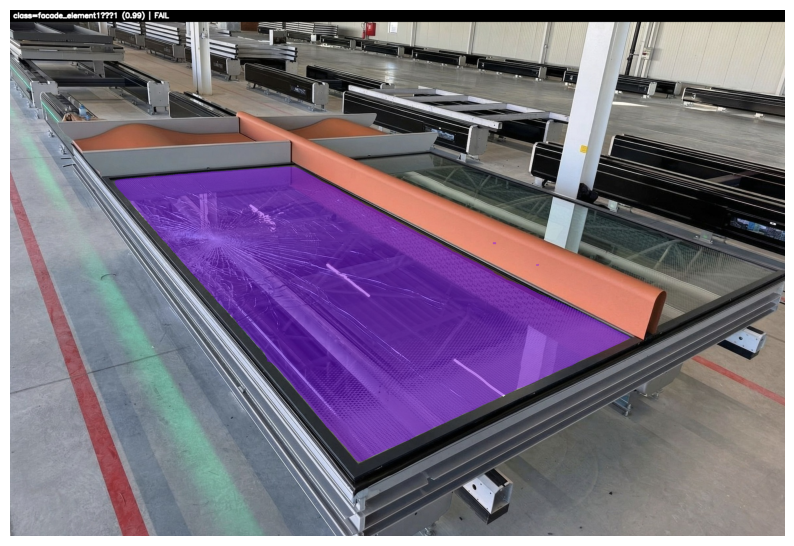

In [89]:
img = load_image(IMAGE_PATH)

inf = detector.infer(img, debug=True)

print(detector.make_solution_report(IMAGE_PATH, inf))
#print(detector.make_solution_report(IMAGE_PATH, inf))

viz = detector.visualize(img, inf)
plt.figure(figsize=(10, 7))
plt.imshow(viz)
plt.axis("off")
plt.show()

# If you want logs without printing during infer:
# print("\n".join(inf["debug"]))


In [90]:
!pip -q install streamlit pandas numpy opencv-python-headless "Pillow==10.0.1" ultralytics "transformers>=4.45.0" --pre huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 10.0.1 which is incompatible.


In [91]:
from google.colab import files
uploaded = files.upload()  # upload facade_defect_streamlit_bundle.zip

!unzip -o facade_defect_streamlit_bundle.zip

Saving facade_defect_streamlit_bundle.zip to facade_defect_streamlit_bundle.zip
Archive:  facade_defect_streamlit_bundle.zip
   creating: facade_defect_streamlit_bundle/
  inflating: facade_defect_streamlit_bundle/README.md  
   creating: facade_defect_streamlit_bundle/__pycache__/
  inflating: facade_defect_streamlit_bundle/__pycache__/facade_defect_model.cpython-311.pyc  
  inflating: facade_defect_streamlit_bundle/app.py  
  inflating: facade_defect_streamlit_bundle/facade_defect_model.py  
  inflating: facade_defect_streamlit_bundle/facade_yolov8n_best.pt  
  inflating: facade_defect_streamlit_bundle/requirements.txt  


In [94]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.environ["YOLO_WEIGHTS"] = "/content/drive/MyDrive/Neodata Hackathon 2025/YOLO/models/facade_yolov8n_best.pt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
from huggingface_hub import login
login()

In [95]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /usr/local/bin/cloudflared
!chmod +x /usr/local/bin/cloudflared

In [97]:
!cloudflared --version

cloudflared version 2025.11.1 (built 2025-11-07-16:59 UTC)


In [103]:
!streamlit run /content/facade_defect_streamlit_bundle/app.py --server.port 8501 --server.address 0.0.0.0 --server.headless true &>/content/streamlit.log &

In [104]:
!ss -ltnp | grep 8501 || true
!curl -I http://127.0.0.1:8501 | head
!tail -n 50 /content/streamlit.log

LISTEN 0      128          0.0.0.0:8501       0.0.0.0:*    users:(("streamlit",pid=21391,fd=6))   
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  1522    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
HTTP/1.1 200 OK
Server: TornadoServer/6.5.1
Content-Type: text/html
Date: Sun, 14 Dec 2025 02:14:37 GMT
Accept-Ranges: bytes
Etag: "aae97bbcf069860f92fc43a08fd3757ac4c7f24b0657acfaef7f11f1f668fde2a8a9a024108a3a174b45c3feaee0290cf045529cbb8031ae827379420591a49d"
Last-Modified: Sun, 14 Dec 2025 02:05:00 GMT
Cache-Control: no-cache
Content-Length: 1522
Vary: Accept-Encoding



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501



In [ ]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate

2025-12-14T02:14:43Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-14T02:14:43Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-14T02:14:48Z INF +--------------------------------------------------------------------------------------------+
2025-12-14T02:14:48Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-14T02:14:48Z INF |  https://rna-amongst-bases-planner.trycloudflare.com  